In [1]:
import hashtagdeep.utils.colormaps as cm
import hashtagdeep.utils.visualization_utils as viz
import hashtagdeep.utils.metrics as metrics

import os

import torch
import torchvision.transforms as transforms
import albumentations 
import sklearn.model_selection as model_selection
import matplotlib.pyplot as plt

from experiment00 import ExperimentDataModule
from experiment00 import ExperimentSystem

In [2]:
mm = ExperimentSystem.load_from_checkpoint('checkpoints/experiment00/v0/experiment00_loss=1.3748412132263184.ckpt')

dm = ExperimentDataModule('/home/dubrovin/Projects/Data/DFC2022/')
dm.setup()

In [3]:
mm.eval()
mm.to('cuda:1');

In [4]:
item = dm._val_dataset[20]
x, y = item['image'], item['label']

In [5]:
with torch.no_grad():
    _, h, w = x.shape
    pred = torch.empty(h, w, dtype=torch.long)

    window = 256
    width_steps = w // window + 1
    height_steps = h // window + 1

    for i in range(height_steps):
        for j in range(width_steps):
            w0, w1 = window * j, window * (j + 1)
            h0, h1 = window * i, window * (i + 1)

            if w1 > w:
                w0, w1 = w - window, w

            if h1 > h:
                h0, h1 = h - window, h

            pred[h0:h1, w0:w1] = torch.argmax(mm(x[None, :, h0:h1, w0:w1].to('cuda:1')), dim=1).cpu()

pred = pred.to('cpu')

In [6]:
mask = viz.make_image_tensor_for_segmentation_mask(y[None, :], cm.dfc22_labels_color_map).squeeze()
prediction = viz.make_image_tensor_for_segmentation_mask(pred[None, :], cm.dfc22_labels_color_map).squeeze()

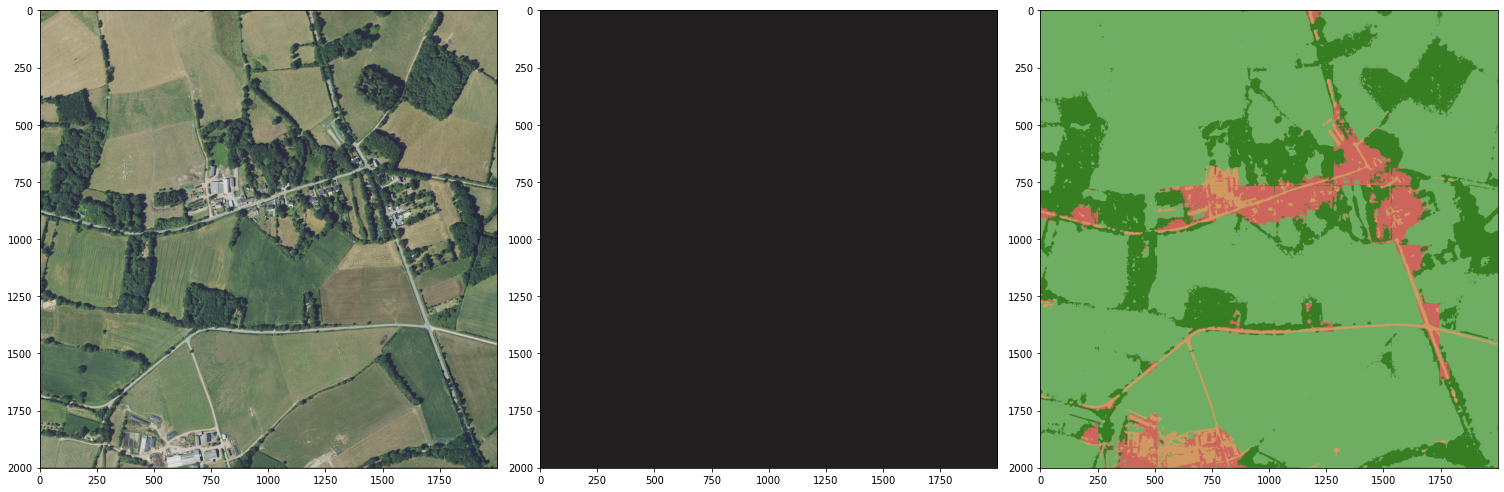

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7), tight_layout=True)
ax[0].imshow(x[:3].permute(1, 2, 0) / 255, interpolation=None)
ax[1].imshow(mask.permute(1, 2, 0), interpolation=None)
ax[2].imshow(prediction.permute(1, 2, 0), interpolation=None);

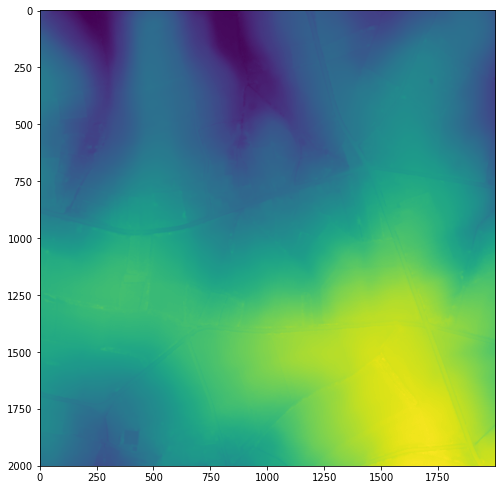

In [8]:
fig, ax = plt.subplots(figsize=(7, 7), tight_layout=True)
ax.imshow(x[3]);

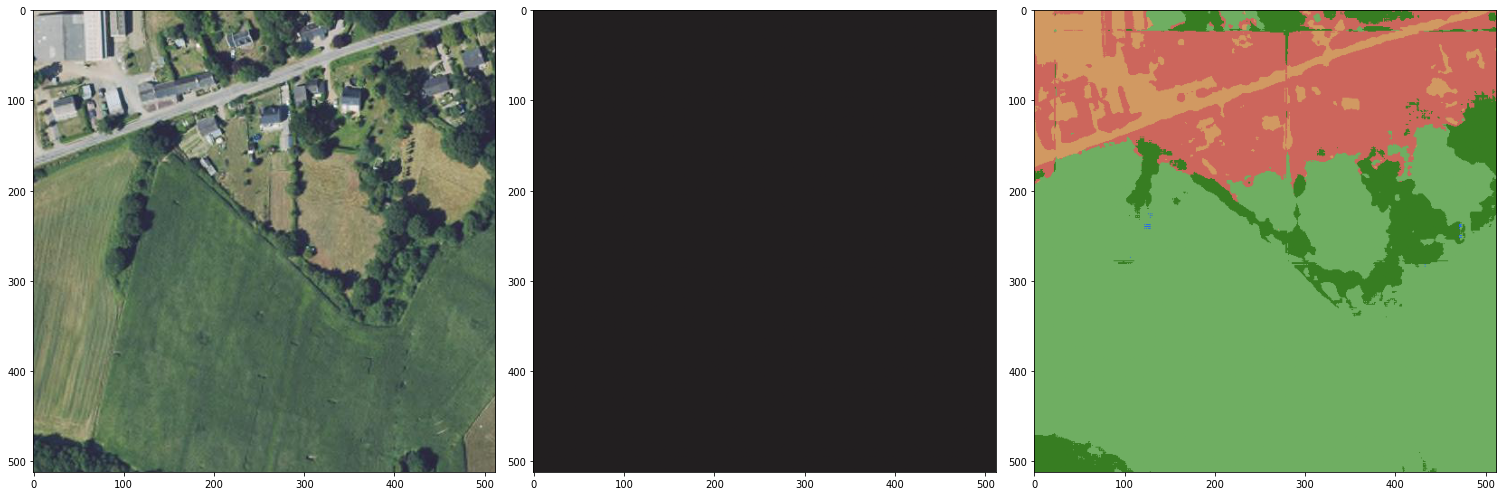

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7), tight_layout=True)
ax[0].imshow(x[:3, 744:1256, 744:1256].permute(1, 2, 0) / 255, interpolation=None)
ax[1].imshow(mask[:, 744:1256, 744:1256].permute(1, 2, 0), interpolation=None)
ax[2].imshow(prediction[:, 744:1256, 744:1256].permute(1, 2, 0), interpolation=None);

In [10]:
unique, count = pred.unique(return_counts=True)
for u, c in zip(unique, count):
    print(f'{u:>2} {c:>1}')

 0 238039
 1 139809
 6 2905355
 9 718170
13 627


In [11]:
unique, count = y.unique(return_counts=True)
for u, c in zip(unique, count):
    print(f'{u:>2} {c:>1}')

-1 4002000


In [12]:
intersection = torch.empty(14, dtype=torch.int32)
union = torch.empty(14, dtype=torch.int32)
target = torch.empty(14, dtype=torch.int32)

for i in range(14):
    intersection[i] = torch.logical_and(pred == i, y == i).count_nonzero(dim=(0, 1))
    union[i] = torch.logical_or(pred == i, y == i).count_nonzero(dim=(0, 1))
    target[i] = torch.count_nonzero(y == i, dim=(0, 1))

In [13]:
torch.mean(intersection / (union + 1e-8))

tensor(0.)

In [16]:
torch.save(
    obj=mm.net.state_dict(),
    f='checkpoints/state_dicts_for_submission_models/experiment00_v0.pt',
)